### RTM Acústico Explicito

__________________

In [1]:
% matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.animation
import matplotlib
import numpy as np
from numba import njit, prange

## Modelagem Direta

$$ p_{ik}^{n+1} = \beta c_{ik}^2 \left[ -p_{i-2k}^n+16p_{i-1k}^n+16p_{i+1k}^n-p_{i+2k}^n -p_{ik-2}^n+16p_{ik-1}^n+16p_{ik+1}^n-p_{ik+2}^n-60p_{ik}^n \right] +\Delta t^2 c_{ik}^2 \ s_{ik}^n +2p_{ik}^n-p_{ik}^{n-1}  $$

#### Loop simples

In [3]:
@njit(parallel=True)
def stepScalar(u_tp1, u_t, u_tm1, c, x1, x2, z1, z2, dx, dz, dt):
    """
    Perform a single time step in the Finite Difference solution for scalar
    waves 4th order in space
    """    
    cdz = (dt/dz)**2
    cdx = (dt/dx)**2

    for i in prange(z1, z2):
        for j in prange(x1, x2):
            u_tp1[i,j] = (2.*u_t[i,j] - u_tm1[i,j]
                + (c[i,j]**2)*(
                    cdx*(-u_t[i,j + 2] + 16.*u_t[i,j + 1] - 30.*u_t[i,j] +
                    16.*u_t[i,j - 1] - u_t[i,j - 2])/12. +
                    cdz*(-u_t[i + 2,j] + 16.*u_t[i + 1,j] - 30.*u_t[i,j] +
                    16.*u_t[i - 1,j] - u_t[i - 2,j])/12.))    

##### Absorção 2 ordem

In [4]:
@njit(parallel=True)
def nonreflexive2nd(u_tp1, u_t, u_tm1, c, nx, nz, dx, dz, dt):
    """
    Apply the boundary conditions: free-surface at top, transparent in the borders
    4th order (+2-2) indexes
    Uses Reynolds, A. C. - Boundary conditions for numerical solution of wave propagation problems
    Geophysics p 1099-1110 - 1978
    We apply 1D reynolds at -2/-1 and +2/+1 respectively
    """
    for i in range(nz):
        # left
        for p in range(2):
                u_tp1[i, p] = ( u_t[i, p] + u_t[i, p+1] - u_tm1[i,p+1] +
                (c[i, p]*dt/dx)*(u_t[i, p+1] - u_t[i, p] - u_tm1[i, p+2] + u_tm1[i, p+1])
                )
        #right
        for p in range(2):
            p = 1-p            
            u_tp1[i, nx-2+p] = ( u_t[i, nx-2+p] + u_t[i, nx-3+p] - u_tm1[i, nx-3+p] -
                (c[i, nx-2+p]*dt/dx)*(u_t[i, nx-2+p] - u_t[i, nx-3+p] - u_tm1[i, nx-3+p] + u_tm1[i, nx-4+p])
                )
    # Down
    for i in range(nx):
        for p in range(2):
            p = 1-p
            u_tp1[nz-2+p, i] = ( u_t[nz-2+p, i] + u_t[nz-3+p, i] - u_tm1[nz-3+p, i] -
                    (c[nz-2+p, i]*dt/dz)*(u_t[nz-2+p, i] - u_t[nz-3+p, i] - u_tm1[nz-3+p, i] + u_tm1[nz-4+p, i])
                    )
        # Up
        for p in range(2):            
            u_tp1[p, i] = ( u_t[p, i] + u_t[p+1, i] - u_tm1[p+1, i] +
                    (c[p, i]*dt/dz)*(u_t[p+1, i] - u_t[p, i] - u_tm1[p+2, i] + u_tm1[p+1, i])
                    )

##### Damping Cerjan

$$ e^{-\alpha(i-nx)} $$

Text(0.5,0,'grid points')

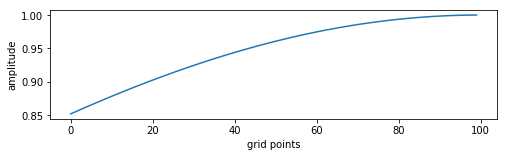

In [5]:
decay=0.004
pad=100
ix = np.arange(0, pad)
plt.figure(figsize=(8,2))
plt.plot(ix, np.exp(-(decay*(pad-ix))**2))
plt.ylabel('amplitude')
plt.xlabel('grid points')

In [6]:
@njit(parallel=True)
def applyDamping(array, nx, nz, pad, decay):
    """
    Apply a decay factor to the values of the array in the padding region.
    """
    # Damping on the left
    for i in prange(nz):
        for j in range(pad):
            array[i,j] *= np.exp(-((decay*(pad - j))**2))
    # Damping on the right
    for i in prange(nz):
        for j in range(nx - pad, nx):
            array[i,j] *= np.exp(-((decay*(j - nx + pad))**2))
    # Damping on the bottom
    for i in prange(nz - pad, nz): # down
        for j in range(nx):
            array[i,j] *= np.exp(-((decay*(i - nz + pad))**2))
    # Damping up
    for i in prange(pad): # down
        for j in range(nx): # left-right
            array[i,j] *= np.exp(-((decay*(pad - i))**2))

### modelo de velocidade para migração rtm zero-offset

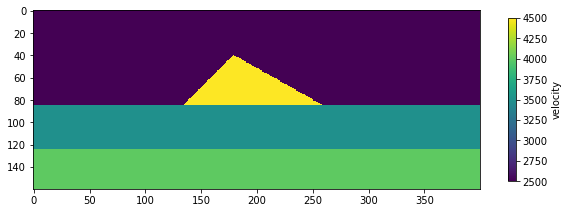

In [7]:
import numpy as np
from PIL import Image
# loading velocity from wedge image file
filename='wedge.tif'
img = Image.open(filename)
img.load()
img = img.convert('I') # gray scale, convert format
velocity  = np.asarray(img, dtype=np.float32)
velocity[:][velocity[:] == 255.0] = 2500.0
velocity[:][velocity[:] == 0.0] = 4500.0
velocity[:][velocity[:] == 146.0] = 3500.0
velocity[:][velocity[:] == 36.0] = 4000.0
plt.figure(figsize=(10,5))
im = plt.imshow(velocity)
plt.colorbar(im,  shrink=0.60, pad = 0.05, label=u'velocity')

### Posição das Fontes

(0, 400)

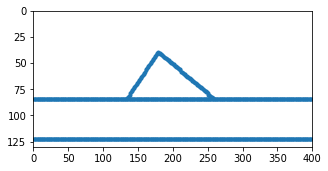

In [8]:
edge = np.abs(np.diff(velocity, axis=0)).astype(np.bool)
indices = np.where(edge > [0])
sz = indices[0]
sx = indices[1]
plt.figure(figsize=(5,2.5))
plt.plot(sx,  sz, '.')
plt.ylim(130, 0) # z
plt.xlim(0, 400) # x

In [9]:
@njit
def applySources(u_tp1, c, sx, sz, source, ns, dt):
    for i in range(ns):
        u_tp1[sz[i],sx[i]] -= ((c[sz[i],sx[i]]*dt)**2)*source  

In [10]:
def ricker(t, td, f):
    """amplitude unitária"""
    t = (t - td)
    aux = (1 - 2*(np.pi*f*t)**2)
    return aux*np.exp(-(np.pi*f*t)**2)

def params(fcut, c):
    """
    A partir da frequencia máxima na fonte `fcut` e do 
    campo de velocidades `c` calcula:
    ds, f central, t delay, dt time step
    """    
    # fcut máxima frequência na fonte
    f = 2*fcut/(3*np.sqrt(np.pi)) # f central
    td = 1./f # time delay    
    lmin = np.min(c)/fcut # lambda min
    ds = lmin/4. # espaçamento grid evitar alias espacial "na lata"
    dt = (1-1e-4)*ds*np.sqrt(3)/(np.sqrt(8)*np.max(c))  # "quaaase" no limite (menor erro)
    return ds, f, td, dt

nz, nx = velocity.shape
npad = 40 # regiao absorcao
# segunda ordem no espaço stencial requer +2+2 pontos cada dimensao
# padding *2 cada dimensao
# padd velocity model with border values
padvel = np.pad(velocity, [npad+2*2, npad+2*2],  mode='edge')
nz, nx = padvel.shape
# correct source positions
sx += npad + 2
sz += npad + 2
ns = len(sx) # number of sources

c = padvel
# campos de pressao em n e n+1 ou n-1
p = np.zeros((2, nz, nx)) # n e n+1 ou n-1
# parametros da simulacao fonte de x0 Hz no máxxximoo...
ds, f, td, dt = params(30., c)
# numero de iteracoes a partir de duracao da simulacao
duracao = 1.950 # segundo
nt = int(duracao/dt)
        
print('Ds: ', ds, 'f. central :', f, 'delay : ', td, 'dt: ',  dt, ' nt: ', nt)

Ds:  20.833333333333332 f. central : 11.283791670955125 delay :  0.0886226925452758 dt:  0.002834774066908449  nt:  687


# Simulation Loop

In [11]:
p = np.zeros((2, nz, nx)) # n e n+1 ou n-1

In [12]:
%%time

snaps = []
for i in range(nt):
    # para evitar um painel a mais : pilha de paineis 
    t, tm1 = i%2, (i+1)%2
    tp1 = tm1  
    
    nonreflexive2nd(p[tp1], p[t], p[tm1], c, nx, nz, ds, ds, dt)
    stepScalar(p[tp1], p[t], p[tm1], c, 2, nx-2, 2, nz-2, ds, ds, dt)
    
    applyDamping(p[tm1], nx, nz, npad, 0.004)
    applyDamping(p[t], nx, nz, npad, 0.004)  
    
    applySources(p[tp1], c, sx, sz, ricker(i*dt, td, f), ns, dt)
    
    if i%1==0:
        snaps.append(p[t].copy())        

snaps = np.array(snaps) # to array

CPU times: user 4.43 s, sys: 548 ms, total: 4.98 s
Wall time: 3.07 s


## Animation Plotting!

In [13]:
plt.rcParams['animation.embed_limit'] = 300 # in MB

In [ ]:
import matplotlib
from matplotlib import animation

apad = npad+2 # 2 additional points space
pmin = np.percentile(snaps, [1])
ext = [0, nx*ds, nz*ds, 0]
fig = plt.figure(figsize=(12,6))
im = plt.imshow(snaps[0,:,:], cmap='gray_r', interpolation='none', vmin=-pmin, vmax=pmin, extent=ext, alpha=0.7)
# boundary without cerjan absortion
plt.plot([apad*ds, (nx-apad)*ds, (nx-apad)*ds, apad*ds, apad*ds], 
         [apad*ds, apad*ds, (nz-apad)*ds, (nz-apad)*ds, (apad)*ds], 'b') 
plt.colorbar(im,  shrink=0.8, pad = 0.01, aspect=10, label=u'amplitude')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
title = plt.title(u'Campo de Pressão')
#sns.despine()
plt.tight_layout()
plt.close()

def animate(i):
    im.set_data(snaps[i, :,:])

ani = animation.FuncAnimation(fig, animate, frames=snaps.shape[0])

from IPython.display import HTML
HTML(ani.to_jshtml())

## Zero-offset Section

In [ ]:
apad = npad+2
plt.figure(figsize=(12,4))
im = plt.imshow(snaps[:, apad, apad:-apad], aspect='auto', cmap='gray_r')
plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')

## Modelagem Reversa

$$ p_{ik}^{n+1} = \beta c_{ik}^2 \left[ -p_{i-2k}^n+16p_{i-1k}^n+16p_{i+1k}^n-p_{i+2k}^n -p_{ik-2}^n+16p_{ik-1}^n+16p_{ik+1}^n-p_{ik+2}^n-60p_{ik}^n \right] +\Delta t^2 c_{ik}^2 \ s_{ik}^n +2p_{ik}^n-p_{ik}^{n-1} \tag{1}$$

$$ p_{ik}^{n-1} = \beta c_{ik}^2 \left[ -p_{i-2k}^n+16p_{i-1k}^n+16p_{i+1k}^n-p_{i+2k}^n -p_{ik-2}^n+16p_{ik-1}^n+16p_{ik+1}^n-p_{ik+2}^n-60p_{ik}^n \right] +\Delta t^2 c_{ik}^2 \ s_{ik}^n +2p_{ik}^n - p_{ik}^{n+1} \tag{2}$$

A equação (2) representa o calculo de diferenças finitas para a reversão no tempo, calculo do tempo passado a partir do futuro. Como pode ser observado a reversão não altera em nada a equação de modelagem direta de equação de onda. Assim na simulação somente deve ser inserido o campo de onda gravado começando pelos últimos tempos.

### Calculate seismogram positions and apply gaussian filter to avoid abrubt changes in the beginning

In [ ]:
seismogram = snaps[:, :, :]
# reverse on time seismogram, multiple sources
seismogram = seismogram[::-1, apad+2, 2+apad:-apad-2]

In [ ]:
decay=0.0031
pad=seismogram.shape[0]
ix = np.arange(0, pad)
filter = np.exp(-(decay*(pad-ix))**2)
#plt.figure(figsize=(8,2))
#plt.plot(ix, filter)
seismogram_filtered = np.asarray(seismogram)
for i in range(400):
    seismogram_filtered[:, i] = seismogram[:, i]*filter

### Sources to be injected back

In [ ]:
plt.figure(figsize=(12,4))
im = plt.imshow(seismogram_filtered, aspect='auto', cmap='gray_r')
plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')

In [ ]:
@njit
def applyMultipleSources(u_tp1, c, sx, sz, source, ns, dt):
    for i in range(ns):
        u_tp1[sz[i],sx[i]] -= ((c[sz[i],sx[i]]*dt)**2)*source[i]  

In [ ]:
def params(fcut, c):
    """
    A partir da frequencia máxima na fonte `fcut` e do 
    campo de velocidades `c` calcula:
    ds, f central, t delay, dt time step
    """    
    # fcut máxima frequência na fonte
    f = 2*fcut/(3*np.sqrt(np.pi)) # f central
    td = 1./f # time delay    
    lmin = np.min(c)/fcut # lambda min
    ds = lmin/4. # espaçamento grid evitar alias espacial "na lata"
    dt = (1-1e-4)*ds*np.sqrt(3)/(np.sqrt(8)*np.max(c))  # "quaaase" no limite (menor erro)
    return ds, f, td, dt

nz, nx = velocity.shape
npad = 40 # regiao absorcao
# segunda ordem no espaço stencial requer +2+2 pontos cada dimensao
# padding *2 cada dimensao
# padd velocity model with border values
padvel = np.pad(velocity, [npad+2, npad+2],  mode='edge')
nz, nx = padvel.shape

c = padvel
# campos de pressao em n e n+1 ou n-1
p = np.zeros((2, nz, nx)) # n e n+1 ou n-1
# parametros da simulacao fonte de x0 Hz no máxxximoo...
ds, f, td, dt = params(30., c)
# numero de iteracoes a partir de duracao da simulacao
duracao = 1.950 # segundo
nt = int(duracao/dt)

### seismometers positions
nzs, nxs = velocity.shape
sx = npad + 2 + np.arange(nxs, dtype=np.int)
sz = npad + 2 + np.zeros(nxs, dtype=np.int)
ns = len(sx) # number of sources
        
print('Ds: ', ds, 'f. central :', f, 'delay : ', td, 'dt: ',  dt, ' nt: ', nt)

# Reverse Time Simulation Loop

In [ ]:
%%time
snaps = []
for i in range(nt):
    # para evitar um painel a mais : pilha de paineis 
    t, tm1 = i%2, (i+1)%2
    tp1 = tm1  
    
    nonreflexive2nd(p[tp1], p[t], p[tm1], c, nx, nz, ds, ds, dt)
    stepScalar(p[tp1], p[t], p[tm1], c, 2, nx-2, 2, nz-2, ds, ds, dt)
    
    applyDamping(p[tm1], nx, nz, npad, 0.004)
    applyDamping(p[t], nx, nz, npad, 0.004)  
    
    applyMultipleSources(p[tp1], c, sx, sz, seismogram_filtered[i].ravel(), ns, dt)
    
    if i%1==0:
        snaps.append(p[t].copy())        
        
snaps = np.array(snaps)

In [ ]:
plt.rcParams['animation.embed_limit'] = 300 # in MB

In [ ]:
import matplotlib
from matplotlib import animation

apad = npad+2 # 2 additional points space
snaps = np.array(snaps)
pmin = np.percentile(snaps, [1])
ext = [0, nx*ds, nz*ds, 0]
fig = plt.figure(figsize=(12,6))
im = plt.imshow(snaps[0,:,:], cmap='gray_r', interpolation='none', vmin=-pmin, vmax=pmin, extent=ext, alpha=0.7)
# boundary without cerjan absortion
plt.plot([apad*ds, (nx-apad)*ds, (nx-apad)*ds, apad*ds, apad*ds], 
         [apad*ds, apad*ds, (nz-apad)*ds, (nz-apad)*ds, (apad)*ds], 'b') 
plt.colorbar(im,  shrink=0.8, pad = 0.01, aspect=10, label=u'amplitude')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
title = plt.title(u'Campo de Pressão')
#sns.despine()
plt.tight_layout()
plt.close()

def animate(i):
    im.set_data(snaps[i, :,:])

ani = animation.FuncAnimation(fig, animate, frames=snaps.shape[0])

from IPython.display import HTML
HTML(ani.to_jshtml())

## Reverse Migrated Section

### overlay velocity model

In [ ]:
# correção devido ao time delta para injeção da fonte, transforma em fase zero
delay = int(td/dt)

In [ ]:
apad = npad+2
plt.figure(figsize=(12,4))
plt.imshow(velocity, aspect='auto')
im = plt.imshow(snaps[-delay, apad:-apad, apad:-apad], aspect='auto', cmap='gray_r', vmin=-1e5, vmax=1e5, alpha=.95)

plt.colorbar(im,  shrink=1, pad = 0.01, aspect=10, label=u'amplitude')